In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11  # Gravitational constant in N*m^2/kg^2
M_sun = 1.989e30  # Solar mass in kg
R_sun = 6.955e8  # Solar radius in m
#K_NR = 1.2435e15  # Constant for non-relativistic electron degenerate gas (cgs units)
m_e = 9.11e-31 #Electron mass in kg
hbar = 1.05457182e-34 #Reduced Planck constant in Js^-1
c = 2.99e8 #Speed of light in ms^-1
a_z = 2
m_n = 1.67e-27 #Neutron mass in kg

In [19]:
def calc_k_f(rho):
    return ((hbar * 3 * np.pi**2 * rho)/(a_z * m_n))**(1/3)

def v(k_f):
    v = (hbar * k_f) / (m_e * c)
    return v


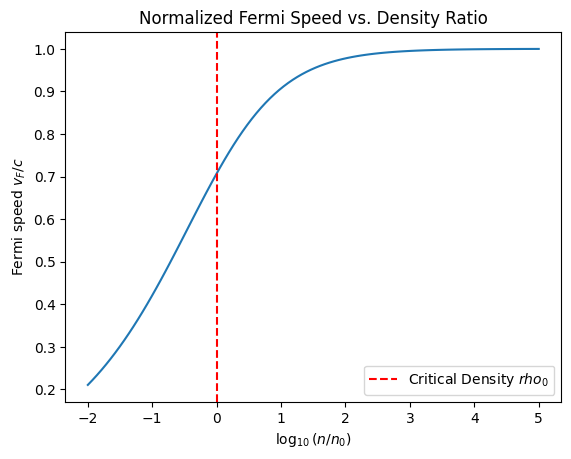

1959110051.0652592

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
m_e = 9.10938356e-31   # Electron mass in kg
c = 2.998e8            # Speed of light in m/s
hbar = 1.05457182e-34  # Reduced Planck constant in J*s

# Critical number density
n0 = m_e**3 * c**3 / (3 * np.pi**2 * hbar**3)
rho0 = n0 * a_z * m_n

# Define Fermi velocity as a function of number density
def fermi_speed_normalized(rho):
    kappa = rho / rho0
    return kappa**(1/3) / np.sqrt(1 + kappa**(2/3))

# Generate number densities and calculate normalized Fermi velocities
n_values = np.logspace(-2, 5, 100) * n0
rho_values = n_values * a_z * m_n
fermi_speeds_normalized = [fermi_speed_normalized(rho) for rho in rho_values]



# Plotting
plt.plot(np.log10(rho_values / rho0), fermi_speeds_normalized)
plt.xlabel(r"$\log_{10}(n / n_0)$")
plt.ylabel(r"Fermi speed $v_F / c$")
plt.axvline(0, color="r", linestyle="--", label="Critical Density $rho_0$")
plt.legend()

plt.title("Normalized Fermi Speed vs. Density Ratio")
plt.show()

rho0

In [24]:
def K_NR():
    """Inverse EOS to get density from pressure for non-relativistic case"""
    return (hbar**2  * (3 * np.pi**2 / (a_z * m_n * c**2))**(5/3)) / (15 * np.pi**2 * m_e)

def K_R():
    """Inverse EOS to get density from pressure for relativistic case"""
    return (hbar* c)/ (12 * np.pi**2)  * (3 * np.pi**2 / (a_z * m_n * c**2))**(4/3)

p0  = K_R() * (rho0 * c**2)**(3/4) #check if should use K_NR or K_R
def eos(P=None, rho=None, rhoi=None, is_pressure_to_density=True):
    
    

    # Select n and K based on whether we are dealing with relativistic or non-relativistic case
    if rhoi > rho0:
        n = 4/3
        K = K_R()
        #print("RELATIVISTIC")
    else:
        n=5/3
        K=K_NR()
        #print("N")
    
    if is_pressure_to_density:  # Calculate density from pressure
        if P is None:
            raise ValueError("Pressure P must be provided for density calculation.")
        return (P / K) ** (1/n) / c**2  # Density from pressure
    
    else:  # Calculate pressure from density
        if rho is None:
            raise ValueError("Density rho must be provided for pressure calculation.")
        
        return K * (rho * c**2) ** n  # Pressure from density

# ----------------- Structure Solver -----------------
def hydrostatic_equilibrium(r, y, rhoi):
    """Equation for hydrostatic equilibrium: y[0]=Pressure, y[1]=Mass"""
    P, M= y
    rho = eos(P=P,rhoi = rhoi, is_pressure_to_density=True)

    dP_dr = (-G * M * rho) / (r**2)
    dM_dr = 4 * np.pi * r**2 * rho
    return [dP_dr, dM_dr]

# ----------------- Event to Stop at Pressure < threshold -----------------
def stop_at_pressure_threshold(r, y, rhoi):
    threshold_pressure = 1e-3  # Define a small threshold for pressure
    return y[0] - threshold_pressure  # Stop when pressure y[0] < threshold_pressure
stop_at_pressure_threshold.terminal = True  # Stop integration when this condition is met
stop_at_pressure_threshold.direction = -1   # Trigger only when pressure is decreasing

# ----------------- Main Integration Function -----------------
def integrate_star(central_pressure, rhoi):
    """Solve the structure equations numerically"""
    radius = 1e11
    
    sol = solve_ivp(
        hydrostatic_equilibrium, 
        [1e-6, radius], 
        [central_pressure, 0],
        method='RK24',
        events=stop_at_pressure_threshold, 
        dense_output=True, 
        max_step=1e5, 
        args = ((rhoi,)),
        rtol=1e-1, 
        atol=1e-6)
    
    return sol.t, sol.y[0], sol.y[1]  # Return radius, pressure, and mass profiles



In [25]:
central_density = 1e11
p0 = eos(rho=central_density, rhoi=central_density, is_pressure_to_density=False)
radius_R, pressure_R, mass_R = integrate_star(p0, central_density)

print(mass_R[-1]/M_sun)

plt.plot(radius_R,mass_R/M_sun)


ValueError: `method` must be one of {'RK23': <class 'scipy.integrate._ivp.rk.RK23'>, 'RK45': <class 'scipy.integrate._ivp.rk.RK45'>, 'DOP853': <class 'scipy.integrate._ivp.rk.DOP853'>, 'Radau': <class 'scipy.integrate._ivp.radau.Radau'>, 'BDF': <class 'scipy.integrate._ivp.bdf.BDF'>, 'LSODA': <class 'scipy.integrate._ivp.lsoda.LSODA'>} or OdeSolver class.

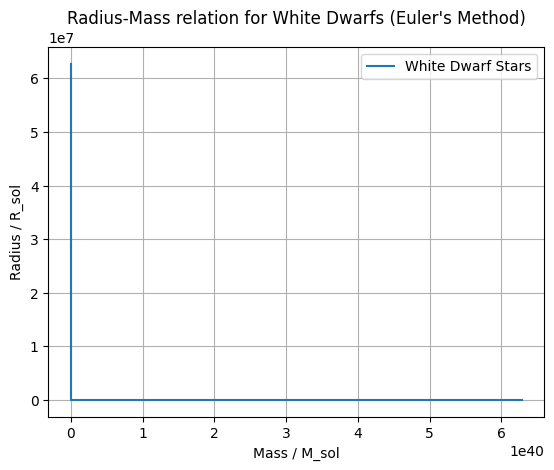

In [ ]:
####Multiple Star

def plot_mass_radius_relation(rho_0s):

    radii = []
    masses = []
    p0s = []

    for rho_0 in rho_0s:
        p0 = eos(rho=rho_0, rhoi= rho_0, is_pressure_to_density=False)
        radius, pressure, mass = integrate_star(p0, rho_0)
        
        threshold = 1e-1
        radius_below_threshold = next(r for r, p in zip(radius, pressure) if p < threshold)
        
        radii.append(radius_below_threshold)
        masses.append(mass[-1])
        p0s.append(p0)

    
    plt.scatter(masses, radii)
    plt.ylabel("Radius / R_sol")
    plt.xlabel("Mass / M_sol")

    
    
    #plt.ylim(0,0.036)
    plt.grid()
    plt.legend()
    plt.title("Radius-Mass relation")
    plt.show()
    
    
    # plt.plot(radii,p0s)
    # plt.title("p0s vs radii")
    # plt.yscale("log")
    # plt.show()


plot_mass_radius_relation(np.logspace(9,10,200))
#plot_mass_radius_relation(np.logspace(6,20,10))




